In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 
import matplotlib.dates as md


warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [5]:
%matplotlib inline

In [6]:
path = r'/Users/helen/Airbnb Project'

In [7]:
reviews_24 = pd.read_csv(os.path.join(path, '01 Data','Prepared Data', 'March 2024', 'reviews_24_clean.csv'), index_col = False)

## Subsets

In [8]:
#creating a subset containing info from 2019-2022 and developing a month-year column

data_2 = reviews_24.reset_index()

In [9]:
reviews_sub_2 = data_2.loc[(data_2['date'] >= '2019-01-01') & (data_2['date'] <= '2022-12-31')]

In [17]:
reviews_sub_2['date'] = pd.to_datetime(reviews_sub_2['date'])

In [18]:
reviews_sub_2['month_year'] = reviews_sub_2['date'].dt.to_period('M')

In [19]:
monthly_review_counts = reviews_sub_2.groupby('month_year').size()

In [20]:
monthly_review_counts.head()

month_year
2019-01    2126
2019-02    2338
2019-03    4035
2019-04    4131
2019-05    5123
Freq: M, dtype: int64

In [21]:
from datetime import datetime

In [22]:
monthly_review_counts.index = monthly_review_counts.index.astype(str)

In [23]:
monthly_review_counts.index = pd.to_datetime(monthly_review_counts.index, infer_datetime_format=True)

In [24]:
monthly_review_counts = monthly_review_counts.sort_index()

I chose to create a subset of my data that spanned 2019-2022 as I felt it may be interesting to examine the impact of covid-19 on Airbnb's review rate. I wanted to zoom in on the immediate period before and after the brunt of the corona pandemic (2020-2021).

## Smoothing

In [38]:
window_size = 5  # Adjust as needed

In [39]:
smoothed_data = monthly_review_counts.rolling(window=window_size).mean()

In [47]:
smoothed_data.isnull().sum()

4

In [48]:
smoothed_data.shape

(48,)

In [49]:
#Imputing missing values

mean_values = smoothed_data.mean()

In [50]:
smoothed_data_filled = smoothed_data.fillna(mean_values)

## Line chart

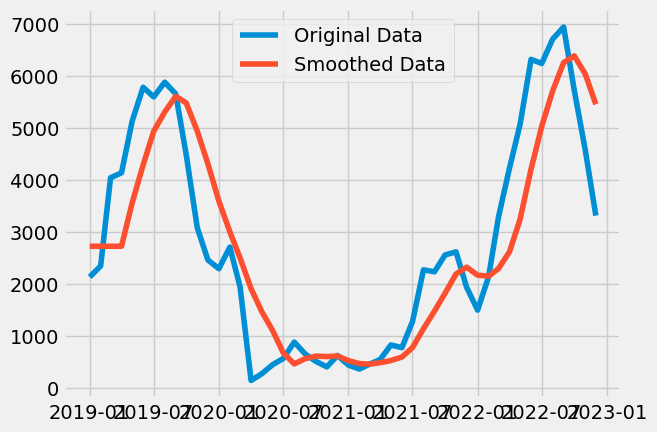

In [51]:
# Plot original data and smoothed data
import matplotlib.pyplot as plt

plt.plot(monthly_review_counts, label='Original Data')
plt.plot(smoothed_data_filled, label='Smoothed Data')
plt.legend()
plt.show()

## Decomposition

In [52]:
decomposition = sm.tsa.seasonal_decompose(smoothed_data_filled, model='multiplicative')

In [53]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

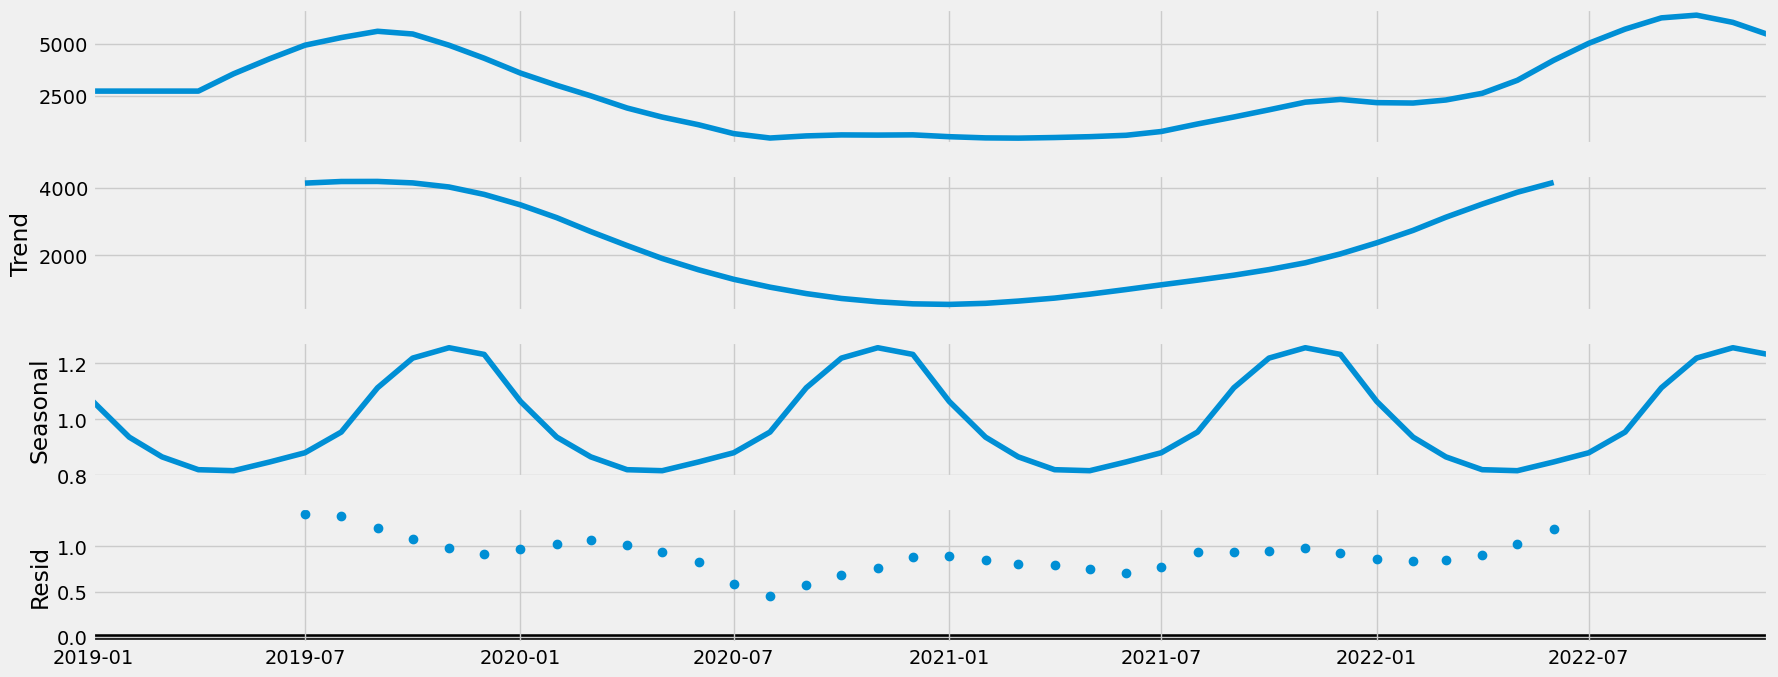

In [54]:
# Plot the separate components

decomposition.plot()
plt.show()

Initially, the original line and trend lines were significantly different which led to me going back and smoothing the data. 

The obvious seasonality seems to have taken sine wave pattern indicating regular fluctuations. 

Despite smoothing, there is still a degree of noise present. 

## Stationarity

In [56]:
ts_values = smoothed_data_filled.values

In [57]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

adf_result = adfuller(ts_values)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Number of Lags Used:', adf_result[2])
print('Number of Observations Used:', adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.6397933243758134
p-value: 0.4623687889055528
Number of Lags Used: 5
Number of Observations Used: 42
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895


If operating with a significance level of 5% in this instance, the critical value is larger than the test statistic, meaning we cannot reject the null hypothesis. This means that there is a unit root in the data, and the data is non-stationary.

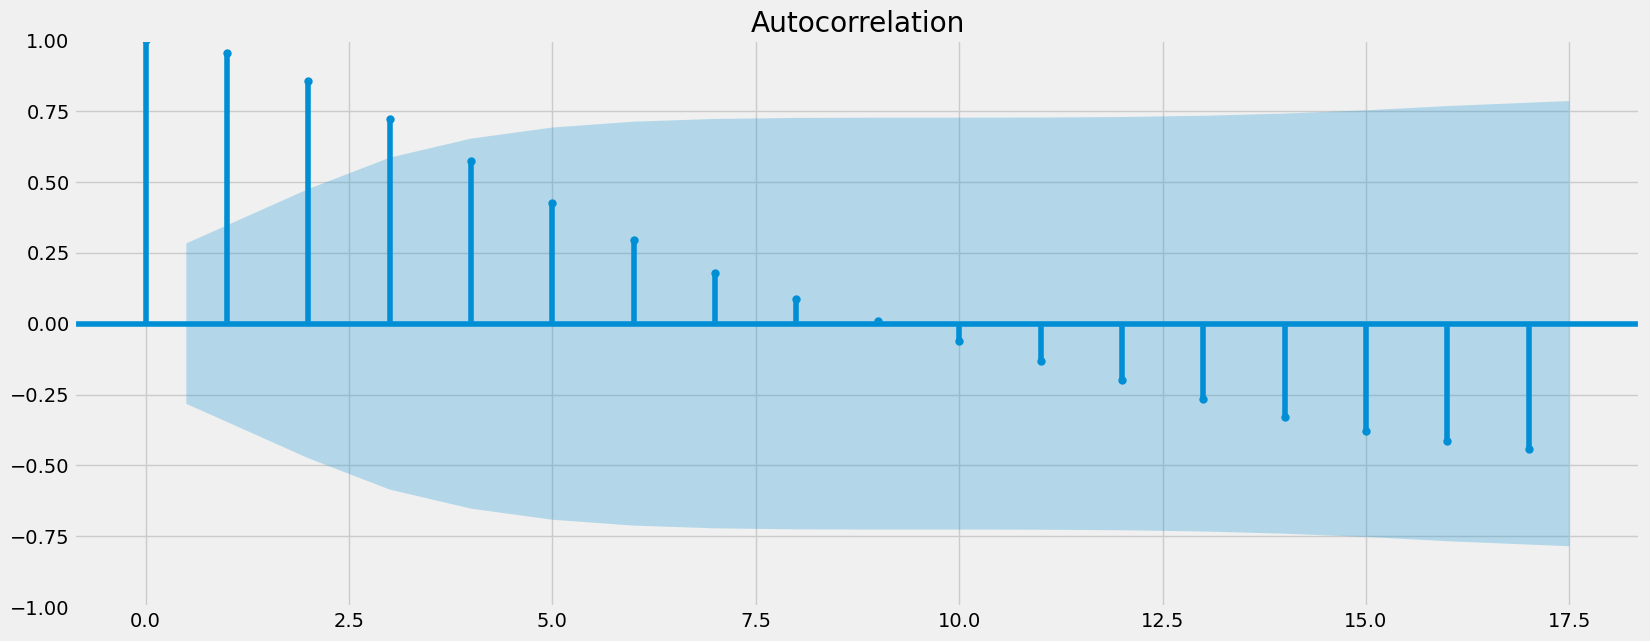

In [58]:
# Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(smoothed_data_filled)
plt.show()

There are not a large amount of lags beyond the confidence interval - this would imply that the data although the data is non-stationary, it is not extremely so. 

## Stationarizing the data

In [64]:
data_diff = smoothed_data_filled - smoothed_data_filled.shift(1) 

In [65]:
data_diff.dropna(inplace = True) 

In [66]:
data_diff.head()

month_year
2019-02-01      0.000000
2019-03-01      0.000000
2019-04-01      0.000000
2019-05-01    833.145455
2019-06-01    730.200000
dtype: float64

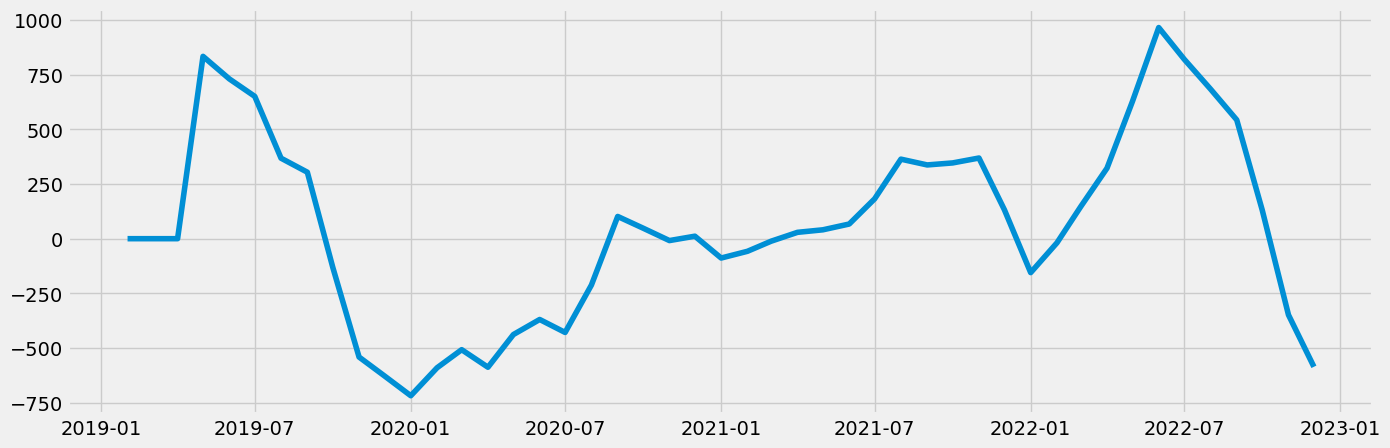

In [67]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [68]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

adf_result = adfuller(data_diff)

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Number of Lags Used:', adf_result[2])
print('Number of Observations Used:', adf_result[3])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.972677095189326
p-value: 0.03752600382245156
Number of Lags Used: 4
Number of Observations Used: 42
Critical Values:
   1%: -3.596635636000432
   5%: -2.933297331821618
   10%: -2.6049909750566895


If operating with a significance level of 5% in this instance, the critical value is smaller than the test statistic, meaning we can now reject the null hypothesis. 

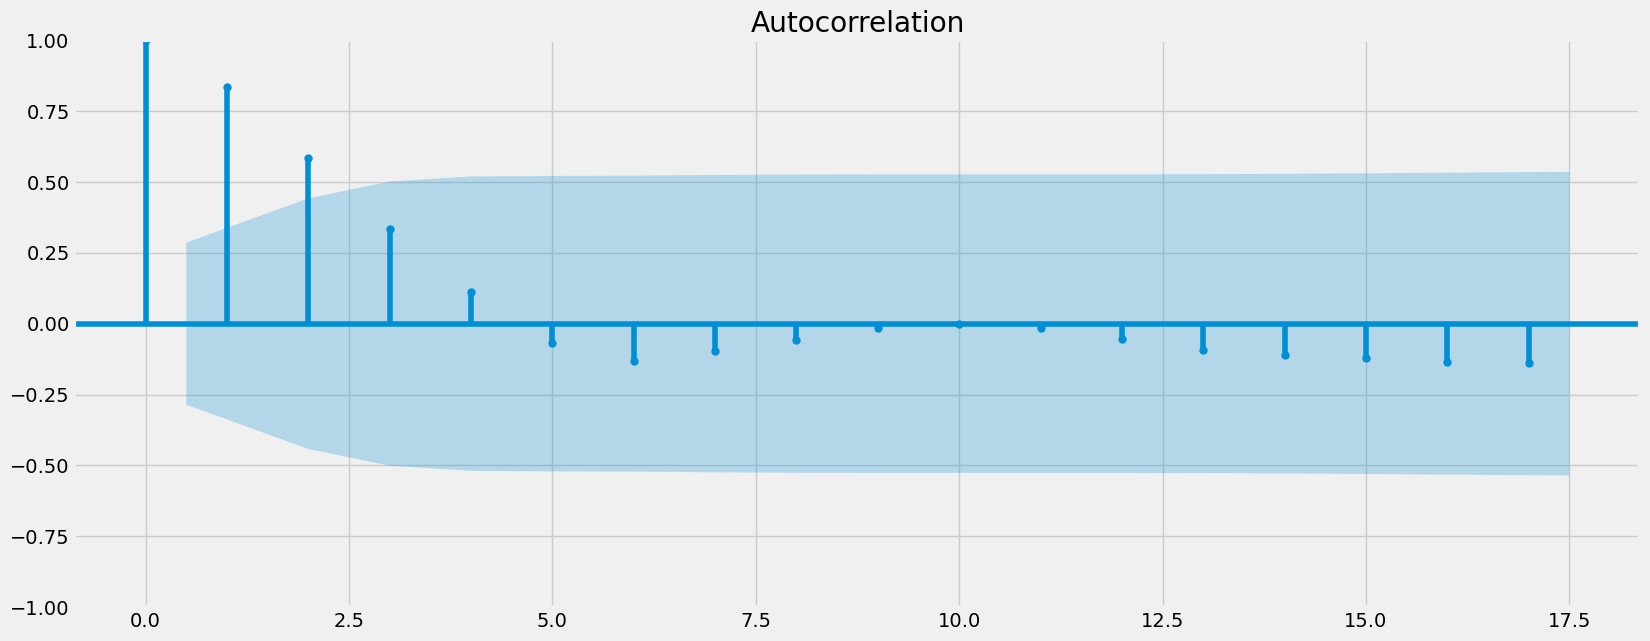

In [69]:
plot_acf(data_diff)
plt.show()

The autocorrelation plot has improved slightly but is still imperfect, so further differencing could be used, however I do not believe it is necessary in this instance. 

